# SMARD API - Daten werden benutzt
https://github.com/bundesAPI/smard-api/tree/main

In [183]:
from datetime import datetime
import pandas as pd
import requests
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

filter = 4169
region = "DE"
resolution_timestamp_request = "hour"
resolution_electricity_request = "quaterhourly"


In [184]:
current_time_seconds = current_datetime = datetime.now()
current_time_milliseconds = int(current_datetime.timestamp() * 1000)
print(current_time_milliseconds)

1712232904776


# Get data from SMARD

Gewichteter Stromgroßhandelspreis (Day-Ahead-Börsenstrompreis) je Stunde [€/MWh] resultierend aus der vortägigen Day-Ahead-Auktion – Datenlieferung erfolgt spätestens 2 Stunden nach Handelsschluss. [Quelle: ENTSO-E]

In [185]:
#Get API posible timestamps (pTimestamp)

# Make a GET request to the REST API of SMARD API
requestURL_pTimestamp = f"https://www.smard.de/app/chart_data/{filter}/{region}/index_{resolution_timestamp_request}.json"
response_pTimestamp = requests.get(requestURL_pTimestamp)

# Check if the request was successful (status code 200)
if response_pTimestamp.status_code == 200:
    # Convert JSON response to Pandas Series
    data = response_pTimestamp.json()
    df_Ptimestamps = pd.DataFrame(data)
    
    # Find the nearest lower timestamp to the current time (not taking the last timestamp, if timestamp looked for is in the past)
    nearest_timestamp = df_Ptimestamps.loc[df_Ptimestamps['timestamps'] <= current_time_milliseconds, 'timestamps'].max()
    print(f"For current time {current_time_milliseconds} ({datetime.fromtimestamp(current_time_milliseconds/1000)}) found nearest API timestamp: {nearest_timestamp} ({datetime.fromtimestamp(nearest_timestamp/1000)})\nDifference (in seconds): {int((current_time_milliseconds-nearest_timestamp)/1000)} \nDifference (in hours): {int((current_time_milliseconds-nearest_timestamp)/(1000*60))}")
else:
    print("Error:", response_pTimestamp.status_code)


For current time 1712232904776 (2024-04-04 14:15:04.776000) found nearest API timestamp: 1711922400000 (2024-04-01 00:00:00)
Difference (in seconds): 310504 
Difference (in hours): 5175


In [186]:
#Get Data from nearest timestamp posible

# Make a GET request to the REST API of SMARD API
requestURL_data = f"https://www.smard.de/app/chart_data/{filter}/{region}/{filter}_{region}_quarterhour_{nearest_timestamp}.json"
response_data = requests.get(requestURL_data)

# Check if the request was successful (status code 200)
if response_data.status_code == 200:
    # Convert JSON response to Pandas Series
    data = response_data.json()
    series_data = data['series']
    df_data = pd.DataFrame(series_data, columns=['timestamp', 'smard_price_E_MWh'])
    # Drop rows with NaN values
    df_data = df_data.dropna()

    # Add column "real_price" with value "true" for non-NaN values
    df_data['day_Ahead'] = True
    df_data['day_Ahead'] = df_data['day_Ahead'].astype(str)
    print(df_data)
else:
    print("Error:", response_pTimestamp.status_code)


         timestamp  smard_price_E_MWh day_Ahead
0    1711922400000              49.95      True
1    1711923300000              49.95      True
2    1711924200000              49.95      True
3    1711925100000              49.95      True
4    1711926000000              48.98      True
..             ...                ...       ...
379  1712263500000              71.47      True
380  1712264400000              61.53      True
381  1712265300000              61.53      True
382  1712266200000              61.53      True
383  1712267100000              61.53      True

[384 rows x 3 columns]


# aWATTar

In [187]:
#aWATTar Information
netzNutzung = 10.88 #cent pro kWh
steuern = 6.68 #cent pro kWh
energieAufschlag = 3/100 #3%
# gesamtpreis -> netzNutzung+steuern+ EPEX Spot DE + 3%
# ACHTUNG -> smard price ist €/MWh 

In [188]:
df_data['awattar_price_E_MWh'] = df_data['smard_price_E_MWh'] + 1000* (netzNutzung + steuern) / 100 + energieAufschlag * df_data['smard_price_E_MWh']
print(df_data)


         timestamp  smard_price_E_MWh day_Ahead  awattar_price_E_MWh
0    1711922400000              49.95      True             227.0485
1    1711923300000              49.95      True             227.0485
2    1711924200000              49.95      True             227.0485
3    1711925100000              49.95      True             227.0485
4    1711926000000              48.98      True             226.0494
..             ...                ...       ...                  ...
379  1712263500000              71.47      True             249.2141
380  1712264400000              61.53      True             238.9759
381  1712265300000              61.53      True             238.9759
382  1712266200000              61.53      True             238.9759
383  1712267100000              61.53      True             238.9759

[384 rows x 4 columns]


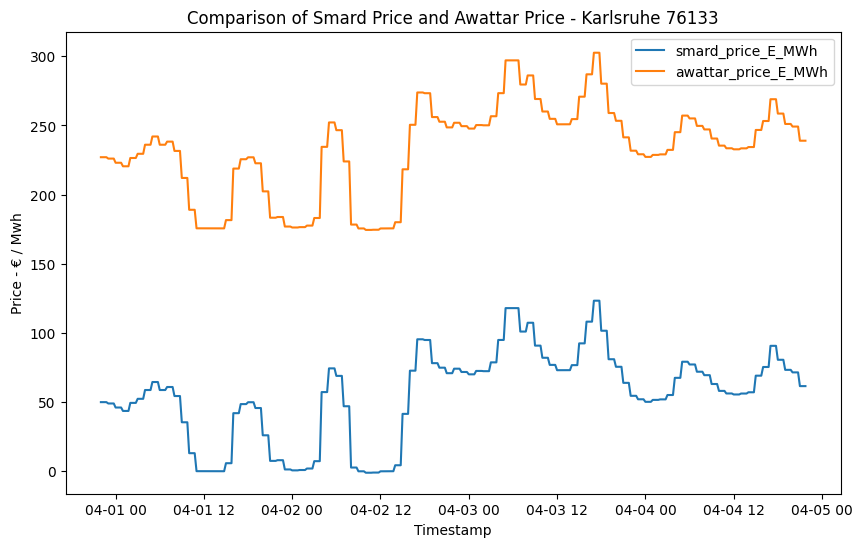

In [189]:
# # Convert timestamp from milliseconds to datetime
# df_data['timestamp'] = pd.to_datetime(df_data['timestamp'], unit='ms')

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(pd.to_datetime(df_data['timestamp'], unit='ms'), df_data['smard_price_E_MWh'], label='smard_price_E_MWh')
plt.plot(pd.to_datetime(df_data['timestamp'], unit='ms'), df_data['awattar_price_E_MWh'], label='awattar_price_E_MWh')

plt.xlabel('Timestamp')
plt.ylabel('Price - € / Mwh')
plt.title('Comparison of Smard Price and Awattar Price - Karlsruhe 76133')
plt.legend()

plt.show()

# Karlsruher Stadtwerke für 76133
Grundpreis	16,18	€ / Monat

In [190]:

karlsruhe_price = 0
grundpreis_karlsruhe = 16.18 # € pro Monat

# Replace 'url_of_webpage' with the actual URL of the webpage you want to fetch
url = "https://www.stadtwerke-karlsruhe.de/de/pk/strom/tarifberater-strom.php?persons=4500&jahresverbrauch=4500&plz=76133+Karlsruhe&bestandskunde=0&onlinekommunikation=1"

# Send a GET request to the webpage
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find all tables in the HTML
    tables = soup.find_all('table')
    
    # Search for the table that starts with "Arbeitspreis"
    desired_table = None
    for table in tables:
        # Find the first row in the table
        first_row = table.find('tr')
        if first_row and first_row.text.strip().startswith("Arbeitspreis"):
            desired_table = table
            break
    
    if desired_table:
        # Process the table as needed
        # For example, you can extract data from the table and create a Pandas DataFrame
        
        # Here is a sample code to print the table's HTML content
        # print(desired_table)
         # Convert the HTML table to a Pandas DataFrame
        df = pd.read_html(str(desired_table))[0]
        df.drop(df.columns[2], axis=1, inplace=True)
        # Print the DataFrame
        # print(df)
        value_in_cents = df.iloc[0, 1] /100 # cents pro kWh
        print(f"Karlsruhe Stadtwerke Preis {value_in_cents} Cents pro kWh")
        karlsruhe_price = value_in_cents / 100 *1000
        print(f"Karlsruhe Stadtwerke Preis {karlsruhe_price} € pro MWh")

        df_data["stadtWerkeKarlsruhe_E_MWh"] = karlsruhe_price
        

    else:
        print("No table starting with 'Arbeitspreis' found.")
else:
    print("Failed to fetch the webpage. Status code:", response.status_code)


Karlsruhe Stadtwerke Preis 35.78 Cents pro kWh
Karlsruhe Stadtwerke Preis 357.8 € pro MWh


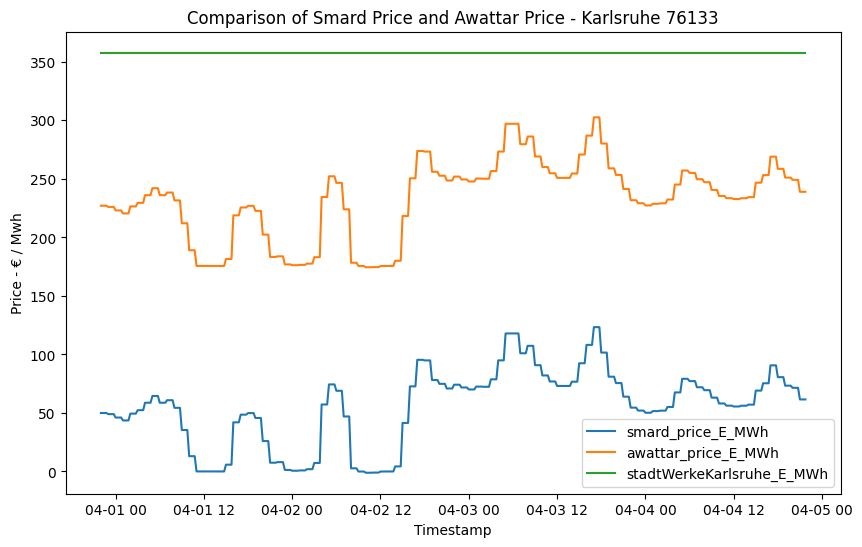

In [191]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(pd.to_datetime(df_data['timestamp'], unit='ms'), df_data['smard_price_E_MWh'], label='smard_price_E_MWh')
plt.plot(pd.to_datetime(df_data['timestamp'], unit='ms'), df_data['awattar_price_E_MWh'], label='awattar_price_E_MWh')
plt.plot(pd.to_datetime(df_data['timestamp'], unit='ms'), df_data['stadtWerkeKarlsruhe_E_MWh'], label='stadtWerkeKarlsruhe_E_MWh')


plt.xlabel('Timestamp')
plt.ylabel('Price - € / Mwh')
plt.title('Comparison of Smard Price and Awattar Price - Karlsruhe 76133')
plt.legend()

plt.show()

# Tibber
https://tibber.com/de?modal=preisrechner

In [192]:
#Grundpreis 
grundpreis_tibber = 15.73 # €/Monat
steuerUndAbgaben = 19.43 # cents pro kWh

df_data['tibber_price_E_MWh'] = df_data['smard_price_E_MWh'] + steuerUndAbgaben



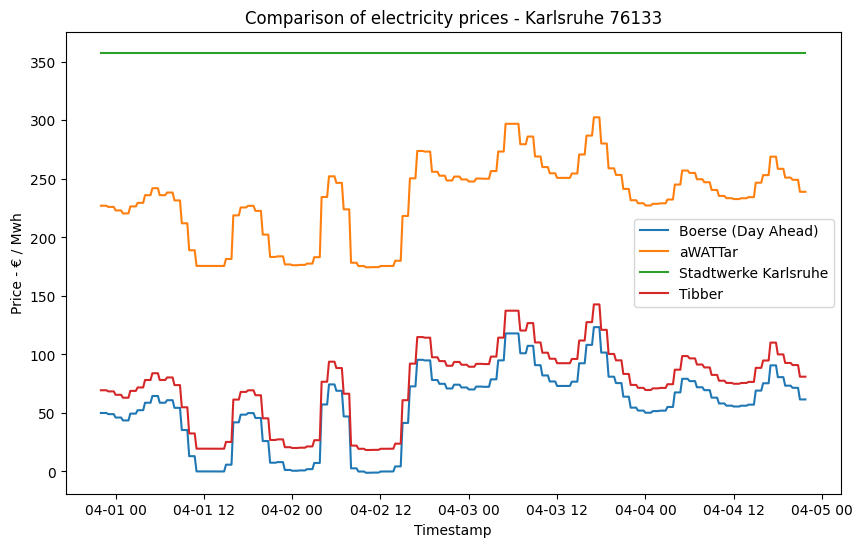

In [193]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(pd.to_datetime(df_data['timestamp'], unit='ms'), df_data['smard_price_E_MWh'], label='Boerse (Day Ahead)')
plt.plot(pd.to_datetime(df_data['timestamp'], unit='ms'), df_data['awattar_price_E_MWh'], label='aWATTar')
plt.plot(pd.to_datetime(df_data['timestamp'], unit='ms'), df_data['stadtWerkeKarlsruhe_E_MWh'], label='Stadtwerke Karlsruhe')
plt.plot(pd.to_datetime(df_data['timestamp'], unit='ms'), df_data['tibber_price_E_MWh'], label='Tibber')


plt.xlabel('Timestamp')
plt.ylabel('Price - € / Mwh')
plt.title('Comparison of electricity prices - Karlsruhe 76133')
plt.legend()

plt.show()

# Save to CSV file


In [194]:
df_data.insert(0,"timestamp_readable",pd.to_datetime(df_data['timestamp'], unit='ms'))
df_data.to_csv("../../data/electricity_price_data.csv", sep=';', header=True, index=False)